In [1]:
#import things
# import Libraries
# Built-in Python libraries
import os # functions for interacting w operating system

# 3rd-party libraries
import numpy as np # module for low-level scientific computing
import pymc3 as pm
import theano.tensor as tt
import pickle
import os
import pandas as pd
import pylab as plt
from scipy import stats

In [2]:
file_list = os.listdir('./')
file_names = []
for files in file_list:
    if files[-2:] == 'h5':      
        file_names.append(files)

for h5 in file_names:
    if 'con' in h5:
        con_df = pd.read_hdf(h5)
    if 'exp' in h5:
        exp_df = pd.read_hdf(h5)

In [3]:
max_time = 20*60000
exp_df = exp_df.loc[exp_df['time'] <= max_time]
con_df = con_df.loc[con_df['time'] <= max_time]

In [4]:
# removed_animals = []
# for df,label in zip([con_df,exp_df],['Control','Experimental']):
#     rm_files = easygui.multchoicebox(
#             msg = 'Which animals will you remove for the LFP analsyis for the %s condition?' %(label),
#             choices = ([x for x in df.Animal.unique()]))
#     removed_animals.append(rm_files)

# #update the dataframes
# try:
#     con_df = con_df.loc[~con_df['Animal'].isin(removed_animals[0])]
# except:
#     con_df

# try:
#     exp_df = exp_df.loc[~exp_df['Animal'].isin(removed_animals[1])]
# except:
#     exp_df

In [5]:
#calculate average for each 1min bin for each condition
# con_df['tbin'] = '';
# exp_df['tbin'] = ''

# for df in [con_df,exp_df]:
#     for tbin in range(0,20):
#         df.loc[(df['time']>=tbin*60000)&\
#                (df['time']<=(tbin+1)*60000),'tbin']=tbin

time_bin_count = 200
con_df['tbin'] = pd.cut(con_df['time'], time_bin_count, labels = np.arange(time_bin_count))
exp_df['tbin'] = pd.cut(exp_df['time'], time_bin_count, labels = np.arange(time_bin_count))

In [6]:
con_means = con_df.loc[con_df['tbin']!=''].groupby(['Animal','Condition','tbin'])['power'].mean().reset_index()
exp_means = exp_df.loc[exp_df['tbin']!=''].groupby(['Animal','Condition','tbin'])['power'].mean().reset_index()

#split frames and substact (condition-wise)
con_split = con_means.loc[con_means.Condition=='Saline'].reset_index()
con_split['diff'] = abs(con_means.loc[con_means.Condition=='Saline'].reset_index()['power']-\
                            con_means.loc[con_means.Condition=='Saline2'].reset_index()['power'])
con_split.drop('index',axis=1,inplace=True)

exp_split = exp_means.loc[exp_means.Condition=='Saline'].reset_index()
exp_split['diff'] = abs(exp_means.loc[exp_means.Condition=='Saline'].reset_index()['power']-\
                            exp_means.loc[exp_means.Condition=='LiCl'].reset_index()['power'])
exp_split.drop('index',axis=1,inplace=True)

# #take the zscore of the power
# zscore = lambda x: (x - x.mean()) / x.std()
# con_split['zscore_diff'] = con_split.groupby(['Animal','Condition'])['diff'].transform(zscore)
# exp_split['zscore_diff'] = exp_split.groupby(['Animal','Condition'])['diff'].transform(zscore)

In [7]:
#create heatmaps of zscored data
con_hm = con_split.pivot("Animal", "tbin", "diff")
exp_hm = exp_split.pivot("Animal", "tbin", "diff")

con_hm = np.asarray(con_hm)
exp_hm = np.asarray(exp_hm)

con_hm = stats.zscore(con_hm,axis=-1)[:,1:]
exp_hm = stats.zscore(exp_hm,axis=-1)[:,1:]

# con_hm = np.mean(con_hm,axis=0)[np.newaxis,:]
# exp_hm = np.mean(exp_hm,axis=0)[np.newaxis,:]

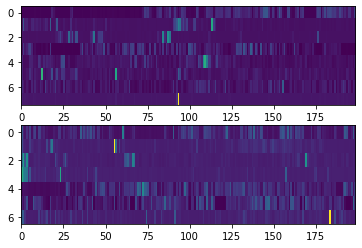

In [8]:
fig, ax = plt.subplots(2,1)
ax[0].imshow(con_hm,aspect='auto')
ax[1].imshow(exp_hm,aspect='auto')

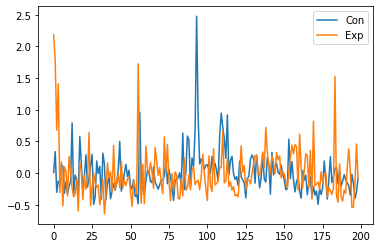

In [9]:
plt.plot(np.mean(con_hm,axis=0),label='Con')
plt.plot(np.mean(exp_hm,axis=0),label='Exp')
plt.legend();

# Changepoint

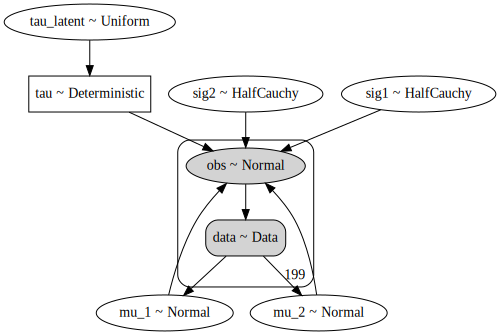

In [10]:
with pm.Model() as model:
    
    data = pm.Data("data", con_hm[0])
    # Defining variables with priors
    alpha = data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    mu_1 = pm.Normal("mu_1", mu=alpha, sigma = 1)
    mu_2 = pm.Normal("mu_2", mu=alpha, sigma = 1)
    sigma1 = pm.HalfCauchy('sig1', 1)
    sigma2 = pm.HalfCauchy('sig2', 1)

    idx = np.arange(con_hm.shape[-1]) # Index
    
    # Uniform prior
    tau_latent = pm.Uniform('tau_latent', 0, 1)
    
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    mu_ = (1 - weight) * mu_1 + weight * mu_2
    sigma_ = (1 - weight) * sigma1 + weight * sigma2


with model:
    observation = pm.Normal("obs", mu=mu_, sigma = sigma_, observed=data)

pm.model_to_graphviz(model)

## Con Data

In [11]:
# Generate one trace for each dataset
traces = []
for data_vals in con_hm:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample(step = pm.Metropolis()))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3962.77draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3907.72draws/s]
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropol

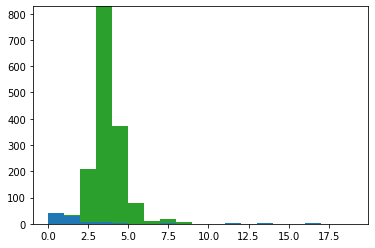

In [24]:
tau_array = np.array([this_trace["tau"] for this_trace in traces])
plt.hist(tau_array.T, np.arange(20), stacked = 'true');

In [14]:
ppcs = [pm.sample_posterior_predictive(this_trace, samples=100, model=model) for this_trace in traces]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 103.69it/s]
/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 105.04it/s]


In [15]:
obs_ppc_array = np.array([this_ppc["obs"] for this_ppc in ppcs])

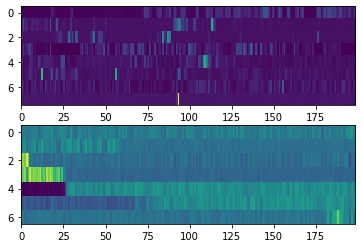

In [22]:
fig,ax=plt.subplots(2,1)
ax[0].imshow(con_hm,aspect='auto')
ax[1].imshow(np.mean(obs_ppc_array,axis=1),aspect='auto')

## Exp Data

In [17]:
# Generate one trace for each dataset
traces = []
for data_vals in exp_hm:
    with model:
        # Switch out the observed dataset
        pm.set_data({"data": data_vals})
        traces.append(pm.sample(step = pm.Metropolis()))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3957.17draws/s]
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:00<00:00, 4014.40draws/s]
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau_latent]
>Metropolis: [sig2]
>Metropolis: [sig1]
>Metropolis: [mu_2]
>Metropolis: [mu_1]

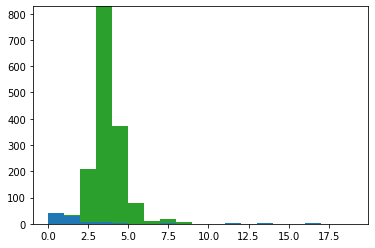

In [18]:
tau_array = np.array([this_trace["tau"] for this_trace in traces])
plt.hist(tau_array.T, np.arange(20), stacked = 'true');

In [19]:
ppcs = [pm.sample_posterior_predictive(this_trace, samples=100, model=model) for this_trace in traces]

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 124.15it/s]


In [20]:
obs_ppc_array = np.array([this_ppc["obs"] for this_ppc in ppcs])

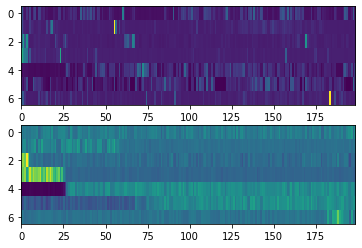

In [23]:
fig,ax=plt.subplots(2,1)
ax[0].imshow(exp_hm,aspect='auto')
ax[1].imshow(np.mean(obs_ppc_array,axis=1),aspect='auto')